# LAPTOP PRICE PREDICTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/HP/OneDrive/Documents/Post_Grad/Semester_2/Machine_Learning/Data/laptopPrice.csv')

In [3]:
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [4]:
print(df.shape)

(823, 19)


In [5]:
df.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

In [6]:
df.duplicated().sum()

21

In [7]:
df = df.drop_duplicates()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 0 to 822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              802 non-null    object
 1   processor_brand    802 non-null    object
 2   processor_name     802 non-null    object
 3   processor_gnrtn    802 non-null    object
 4   ram_gb             802 non-null    object
 5   ram_type           802 non-null    object
 6   ssd                802 non-null    object
 7   hdd                802 non-null    object
 8   os                 802 non-null    object
 9   os_bit             802 non-null    object
 10  graphic_card_gb    802 non-null    object
 11  weight             802 non-null    object
 12  warranty           802 non-null    object
 13  Touchscreen        802 non-null    object
 14  msoffice           802 non-null    object
 15  Price              802 non-null    int64 
 16  rating             802 non-null    object
 1

In [9]:
df.nunique()

brand                  8
processor_brand        3
processor_name        11
processor_gnrtn        8
ram_gb                 4
ram_type               6
ssd                    7
hdd                    4
os                     3
os_bit                 2
graphic_card_gb        5
weight                 3
warranty               4
Touchscreen            2
msoffice               2
Price                405
rating                 5
Number of Ratings    282
Number of Reviews    135
dtype: int64

In [10]:
df.describe()

,Price,Number of Ratings,Number of Reviews
count,802.000000,802.00000,802.000000
mean,76625.543641,299.84414,36.089776
std,45232.984422,1001.78442,118.313553
min,16990.000000,0.00000,0.000000
25%,45990.000000,0.00000,0.000000
50%,63990.000000,17.00000,2.000000
75%,89525.000000,140.25000,18.000000
max,441990.000000,15279.00000,1947.000000


In [11]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object']
cat_features = [feature for feature in df.columns if df[feature].dtype == 'object']
print("Numerical features: ", numeric_features)
print("Categorical featues:", cat_features)

Numerical features:  ['Price', 'Number of Ratings', 'Number of Reviews']
Categorical featues: ['brand', 'processor_brand', 'processor_name', 'processor_gnrtn', 'ram_gb', 'ram_type', 'ssd', 'hdd', 'os', 'os_bit', 'graphic_card_gb', 'weight', 'warranty', 'Touchscreen', 'msoffice', 'rating']


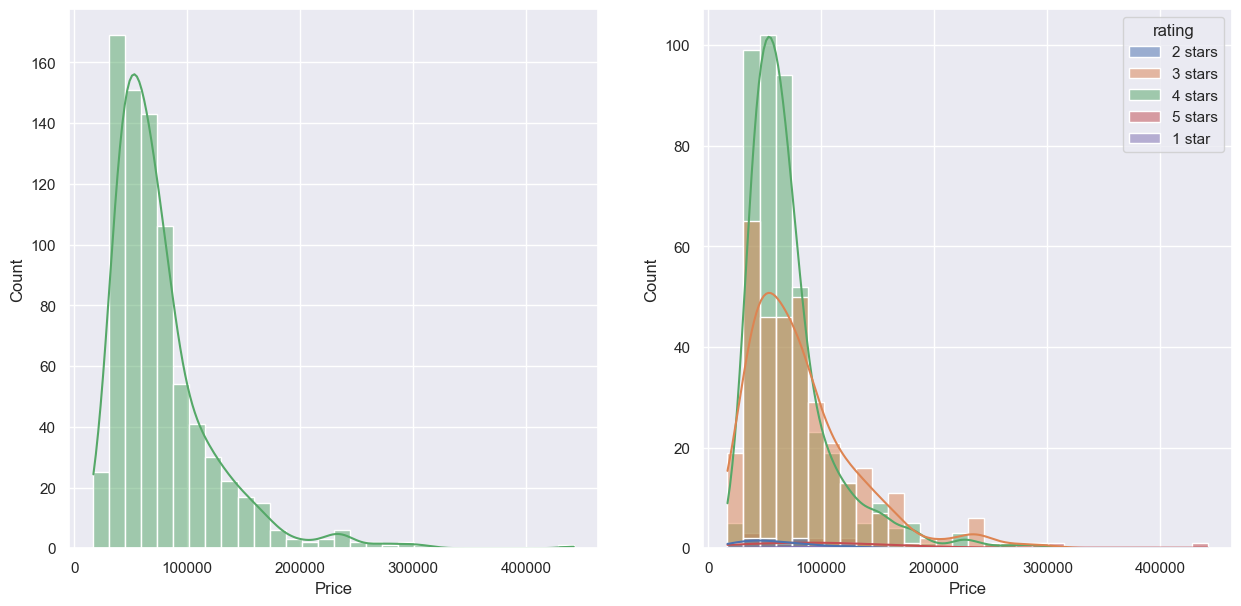

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x= 'Price', bins=30, kde=True, color='g', hue= 'rating')
plt.show()

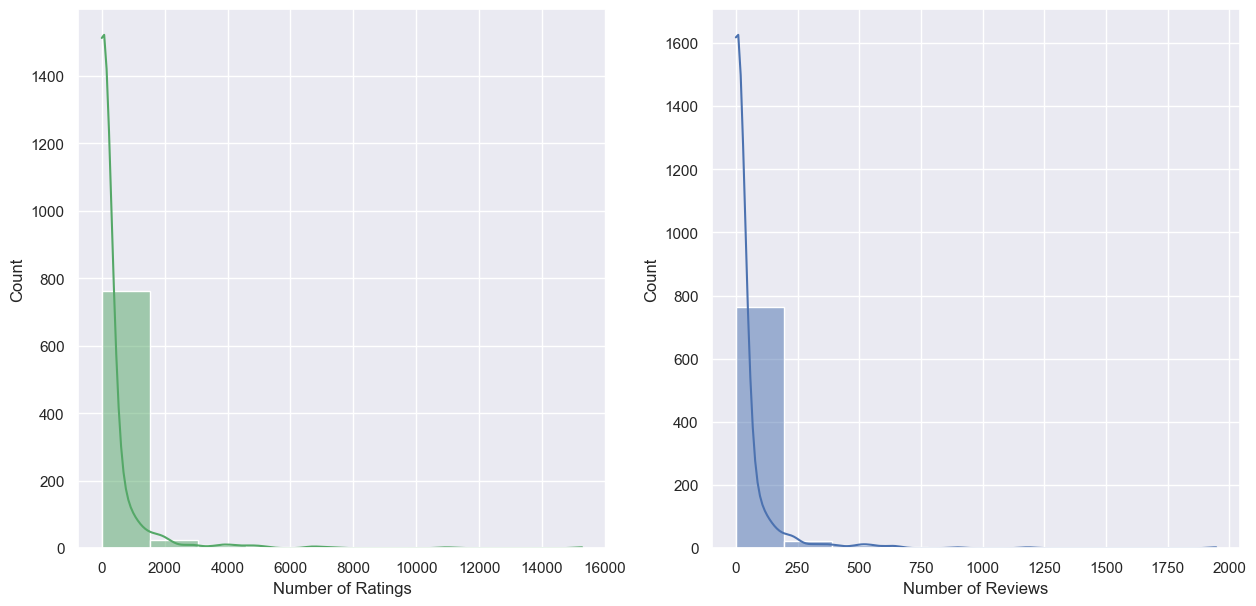

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df,x='Number of Ratings',bins=10,kde=True,color='g')
plt.subplot(122)
sns.histplot(data=df,x='Number of Reviews',kde=True, bins = 10)
plt.show()

In [14]:
def remove_outliers(df, column):
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    iqr = percentile75-percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [15]:
df = remove_outliers(df, 'Price')
df = remove_outliers(df, 'Number of Ratings')
df = remove_outliers(df, 'Number of Reviews')

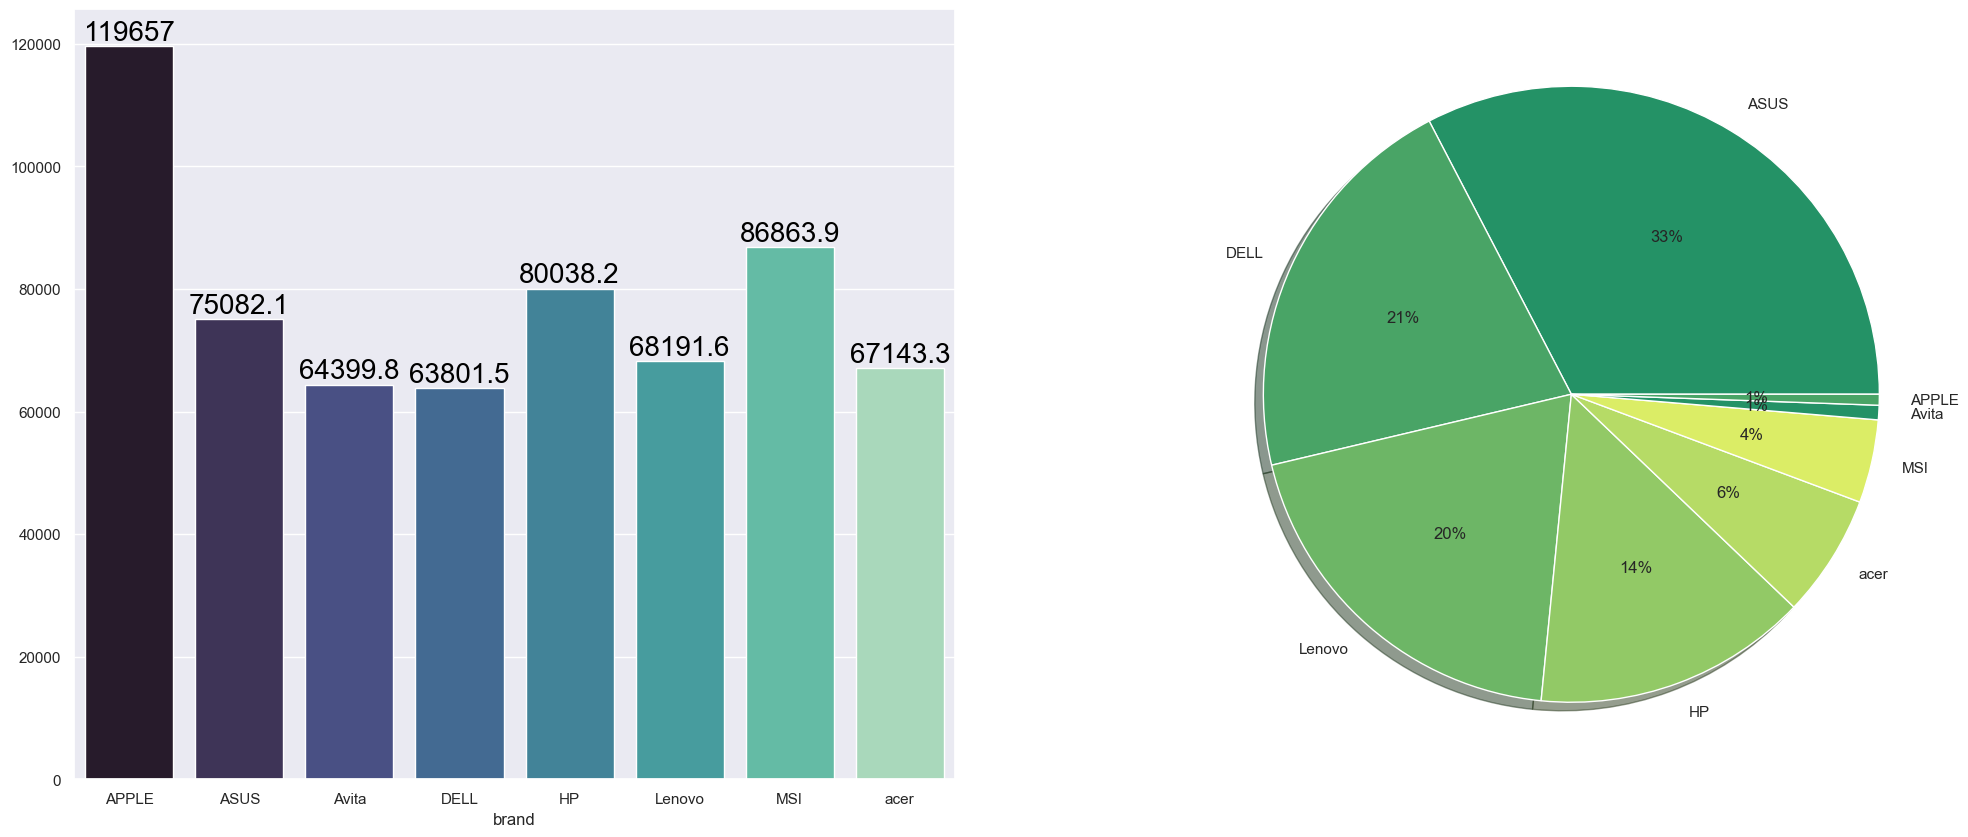

In [16]:
#average cost of laptops brand wise
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
#the number of data values Brand wise
palette_color = sns.color_palette('summer')
plt.pie(x = df['brand'].value_counts(),labels=df['brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

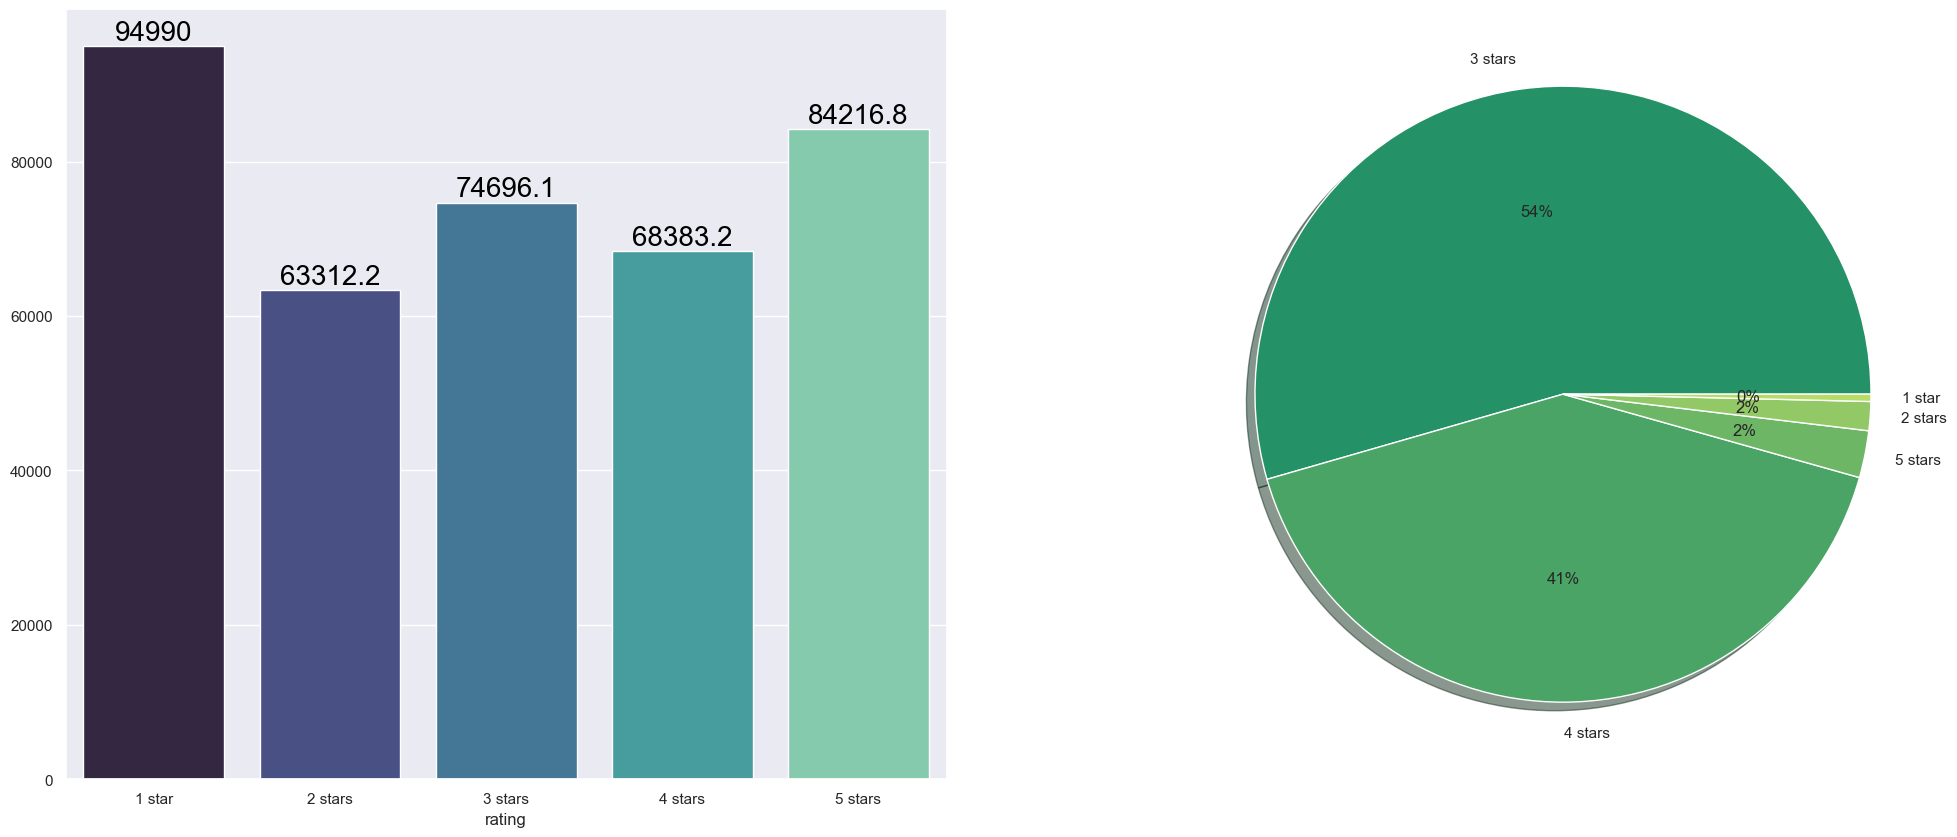

In [17]:
#price value of 1 star,2 star, ...5 star
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('rating')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
#rating distribution
palette_color = sns.color_palette('summer')
plt.pie(x = df['rating'].value_counts(),labels=df['rating'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

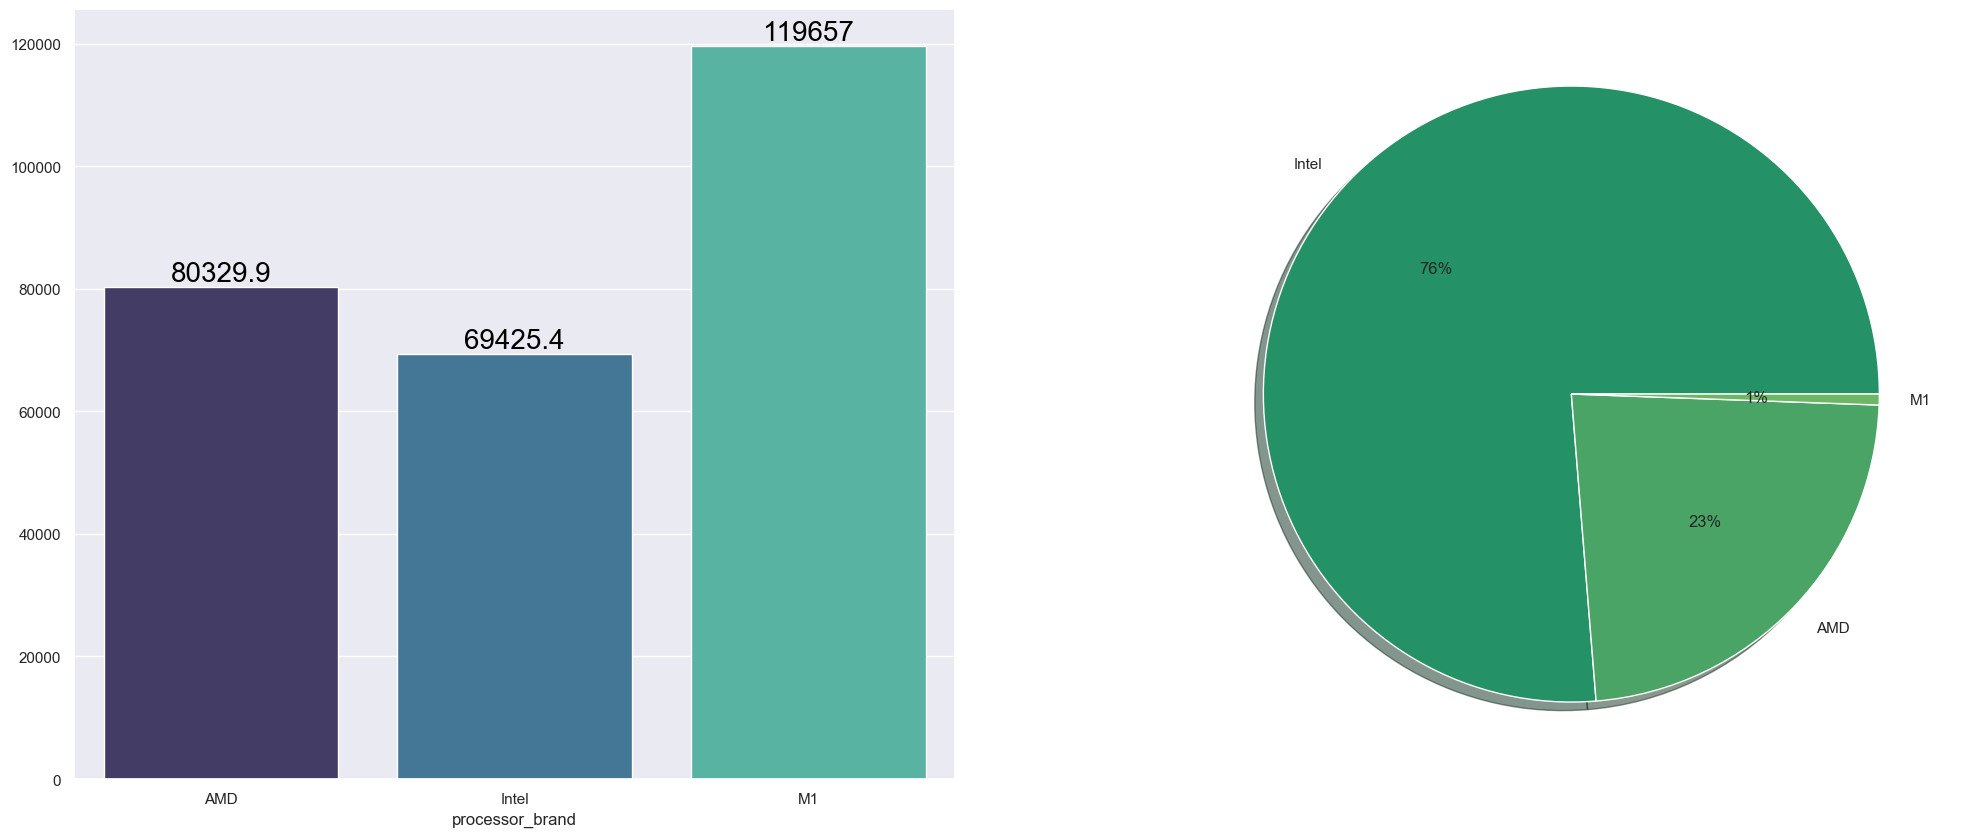

In [18]:
#price value based on processors
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('processor_brand')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)

#distribution of processors
palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_brand'].value_counts(),labels=df['processor_brand'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show()

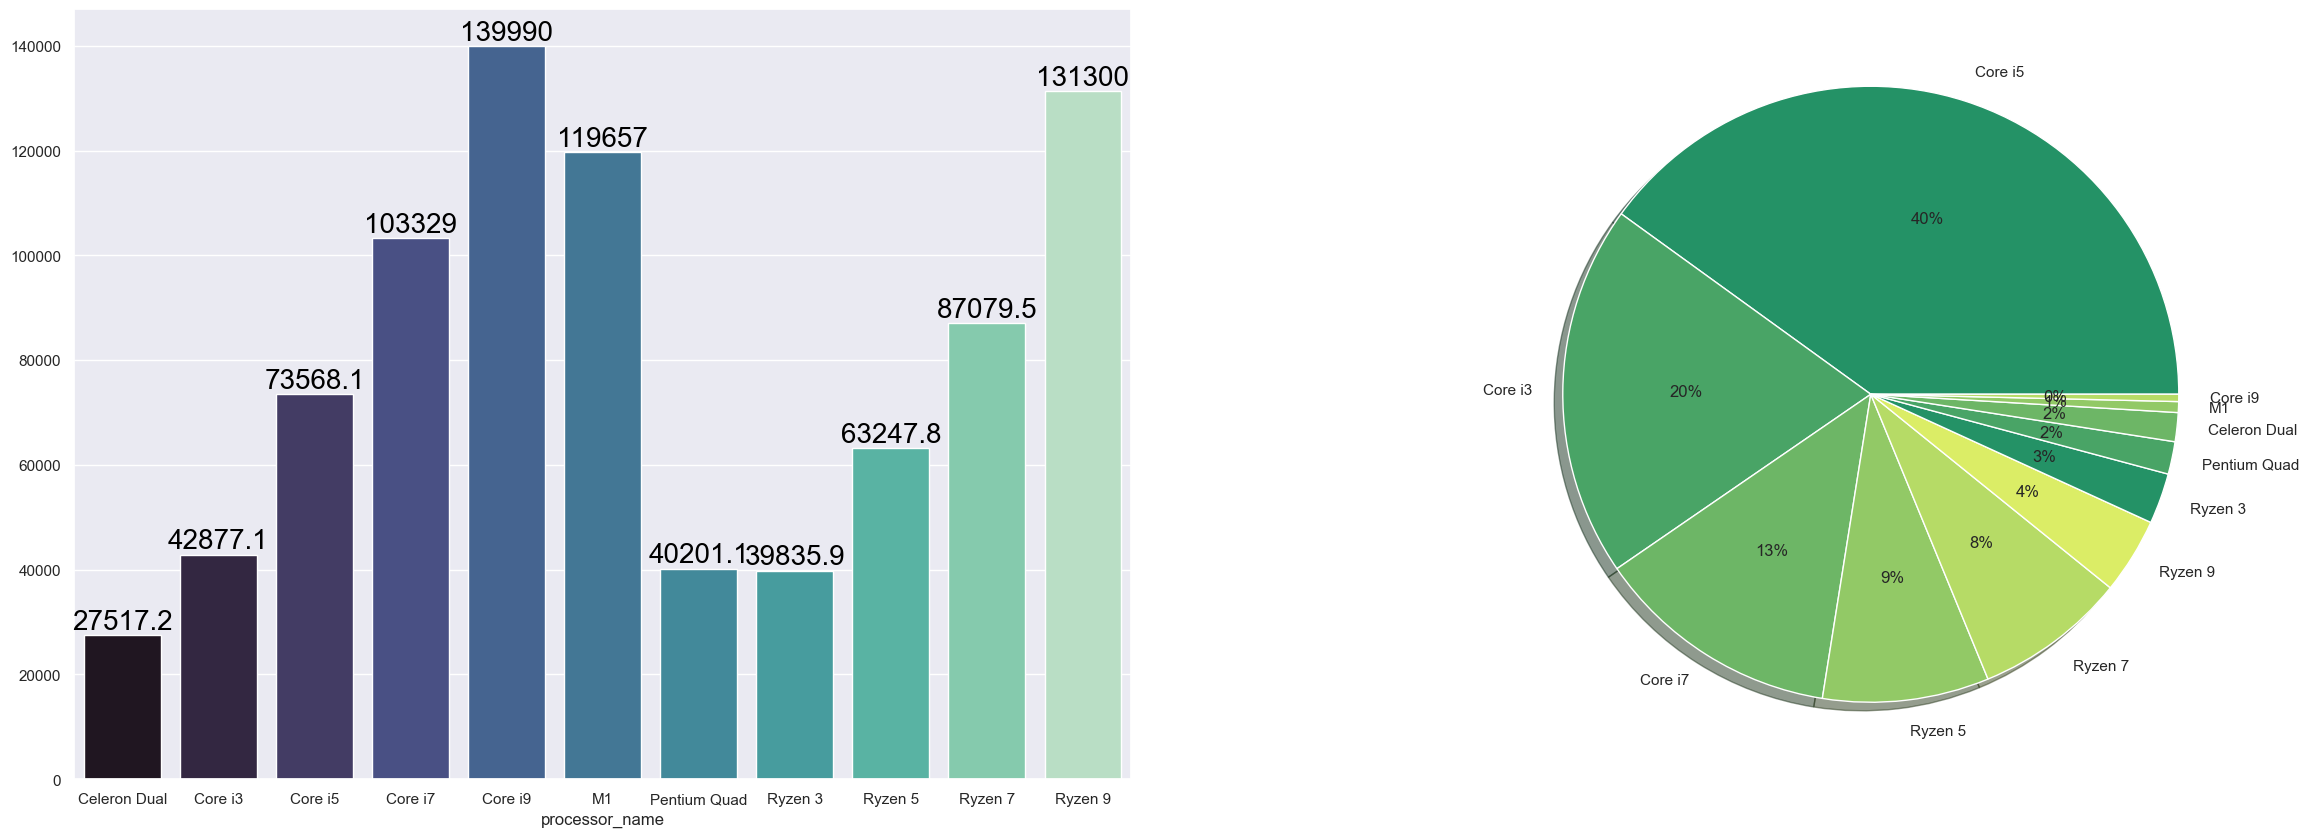

In [19]:
#average pricing of laptops based on the processor name
f,ax=plt.subplots(1,2,figsize=(30,10))
Group_data = df.groupby('processor_name')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)

#distribution of Processor name
palette_color = sns.color_palette('summer')
plt.pie(x = df['processor_name'].value_counts(),labels=df['processor_name'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

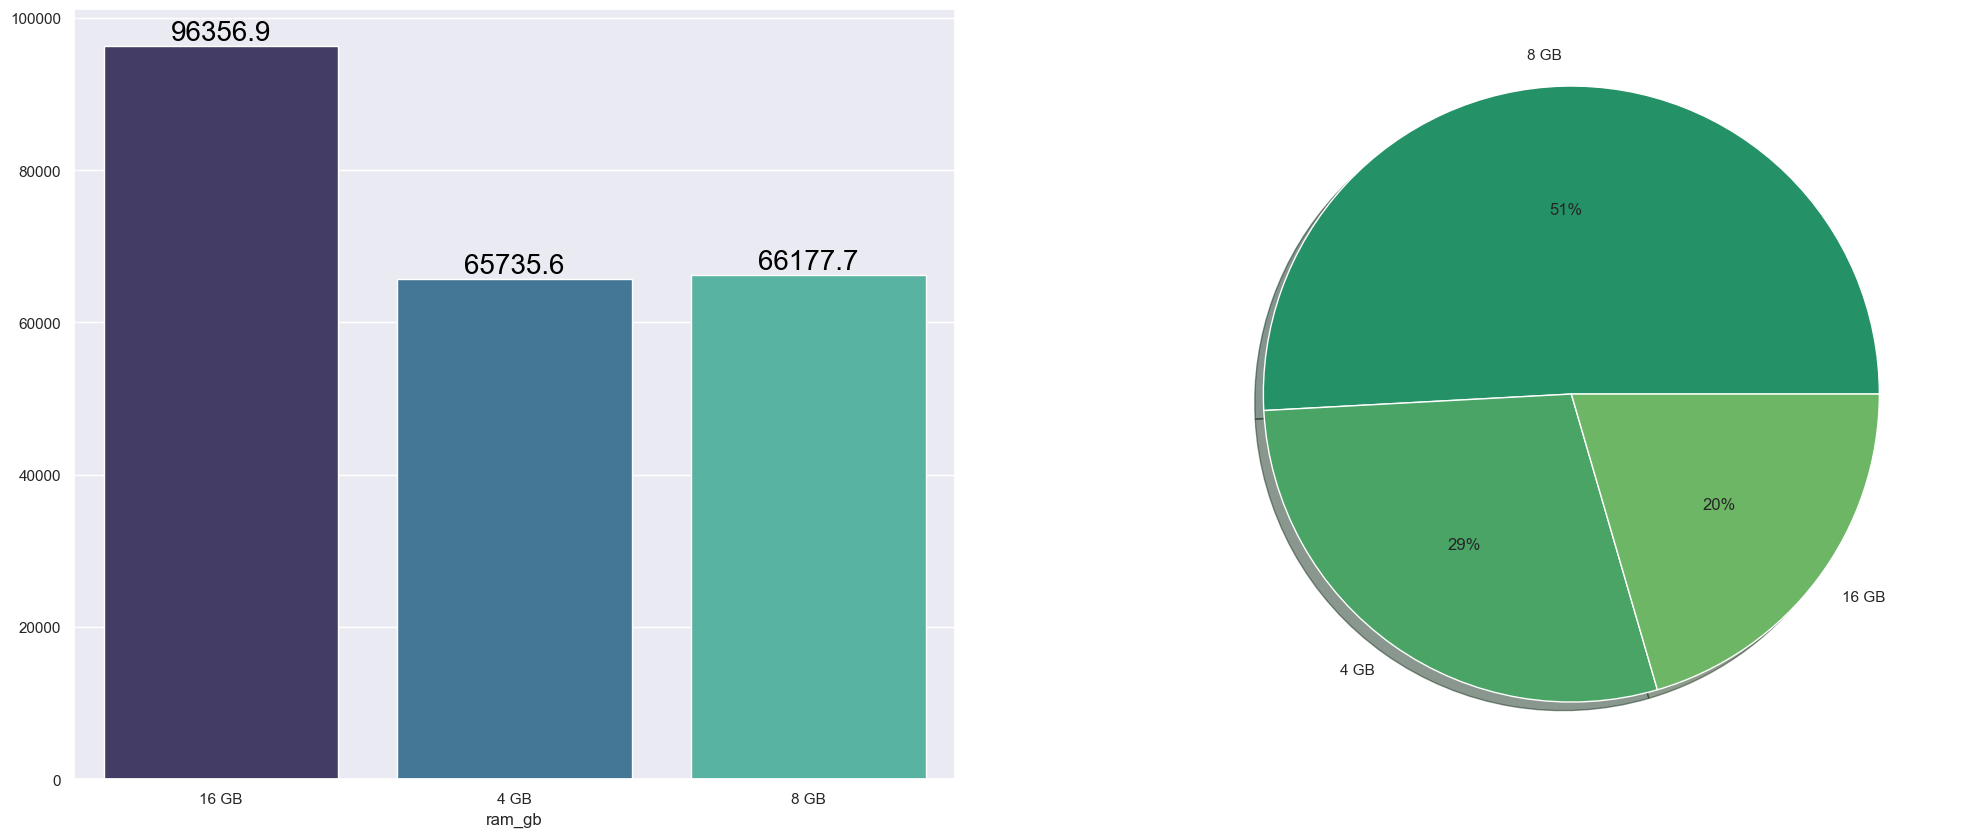

In [20]:
#average pricing of laptops based on the ram
f,ax=plt.subplots(1,2,figsize=(25,10))
Group_data = df.groupby('ram_gb')
sns.barplot(x = Group_data ['Price'].mean().index, y = Group_data['Price'].mean().values,ax= ax[0],  palette = 'mako')
for container in ax[0].containers:
    ax[0].bar_label(container,color='black',size=20)
    
#distribution of ram
palette_color = sns.color_palette('summer')
plt.pie(x = df['ram_gb'].value_counts(),labels=df['ram_gb'].value_counts().index,autopct='%.0f%%',shadow=True, colors= palette_color)
plt.show() 

In [21]:
# class LogScaling(BaseEstimator, TransformerMixin):

#     def fit(self, X):
#         return self   

#     def transform(self, X):
#         return np.log1p(X)

In [22]:
# class TransformationPipeline:

#     def __init__(self) -> None:
#         pass
    
#     def preprocess(self):
#         num_cols = ['Number of Ratings', 'Number of Reviews']

#         num_pipeline= Pipeline(
#             steps=[
#             ("imputer",SimpleImputer(strategy="median")),
#             ("scaler",StandardScaler())
#             ]
#         ) 

#         preprocessor = ColumnTransformer([
#             ("log_transform", LogScaling(), num_cols),
#             ("num_pipeline", num_pipeline, num_cols),
#             ], remainder= 'passthrough')
        
        
#         return preprocessor        

In [23]:
def encode(df):
        label_encoder = LabelEncoder()
        cat_cols = df.select_dtypes('object').columns
        for i in cat_cols:
            df[i] = label_encoder.fit_transform(df[i])
        
        return df

In [24]:
df.brand.unique()

array(['ASUS', 'Lenovo', 'HP', 'acer', 'DELL', 'MSI', 'Avita', 'APPLE'],
      dtype=object)

In [25]:
dfNew=encode(df)
dfNew.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,1,1,1,0,1,1,0,1,2,1,0,0,3,0,0,34649,1,3,0
1,5,1,1,0,1,1,0,1,2,1,0,0,3,0,0,38999,2,65,5
2,5,1,1,0,1,1,0,1,2,1,0,0,3,0,0,39999,2,8,1
3,1,1,2,0,2,1,4,0,2,0,1,0,3,0,0,69990,2,0,0
4,1,1,0,6,1,1,0,2,2,1,0,0,3,0,0,26990,2,0,0


In [26]:
X = dfNew.drop('Price', axis = 1)
y = dfNew.Price

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state= 1)
X_train.shape, X_test.shape

((474, 18), (53, 18))

In [28]:
# preprocessor = TransformationPipeline().preprocess()
# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

In [29]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [30]:
X_train

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,rating,Number of Ratings,Number of Reviews
630,1,1,6,6,1,1,3,0,2,1,0,2,0,0,1,3,7,1
796,1,0,10,6,0,1,1,0,2,1,3,0,0,0,0,2,0,0
500,4,1,3,1,0,1,4,0,2,1,0,0,0,1,1,2,0,0
284,4,1,2,1,2,1,4,0,2,1,0,2,0,0,1,3,40,3
260,3,1,2,0,0,1,4,0,2,1,2,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,4,1,2,1,0,1,4,0,2,1,0,2,0,0,1,3,108,6
242,4,1,2,1,0,1,4,0,2,1,0,2,0,0,1,3,10,0
115,4,1,1,0,1,1,4,0,2,0,0,0,3,0,0,3,30,1
350,5,1,2,1,2,1,4,0,2,1,1,0,3,0,0,2,0,0


In [31]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'lightgbm' : LGBMRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'support vector': SVR(),
    'ada boost regressor': AdaBoostRegressor()
}

In [32]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
lightgbm trained
gradient boosting trained
lasso trained
random forest trained
support vector trained
ada boost regressor trained


In [33]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(79))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'mse', 
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
15/15 [==============================] - 1s 26ms/step - loss: 6024595968.0000 - rmse: 77618.2734 - val_loss: 6201345024.0000 - val_rmse: 78748.6172
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 5669798400.0000 - rmse: 75298.0625 - val_loss: 5333012992.0000 - val_rmse: 73027.4844
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 4348091904.0000 - rmse: 65940.0625 - val_loss: 3673115648.0000 - val_rmse: 60606.2305
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 3391395584.0000 - rmse: 58235.6914 - val_loss: 2927394560.0000 - val_rmse: 54105.4023
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 2604558848.0000 - rmse: 51034.8789 - val_loss: 2067233280.0000 - val_rmse: 45466.8359
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 1669203584.0000 - rmse: 40855.8867 - val_loss: 1348589312.0000 - val_rmse: 36723.1445
Epoch 7/50
15/15 [==============================] -

In [34]:
RMSE_ann = model.evaluate(X_test, y_test)[1]
RMSE_ann

2/2 [==============================] - 0s 2ms/step - loss: 244732128.0000 - rmse: 15643.9170


15643.9169921875

In [35]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result
    
results['ANN'] = RMSE_ann

In [36]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df.T

,support vector,lasso,ridge,ada boost regressor,ANN,lightgbm,random forest,xgboost,catboost,gradient boosting
RMSE,30030.578111,19897.278163,19856.890407,18767.284288,15643.916992,14565.138357,13749.74588,13301.000826,13073.327207,12789.554679


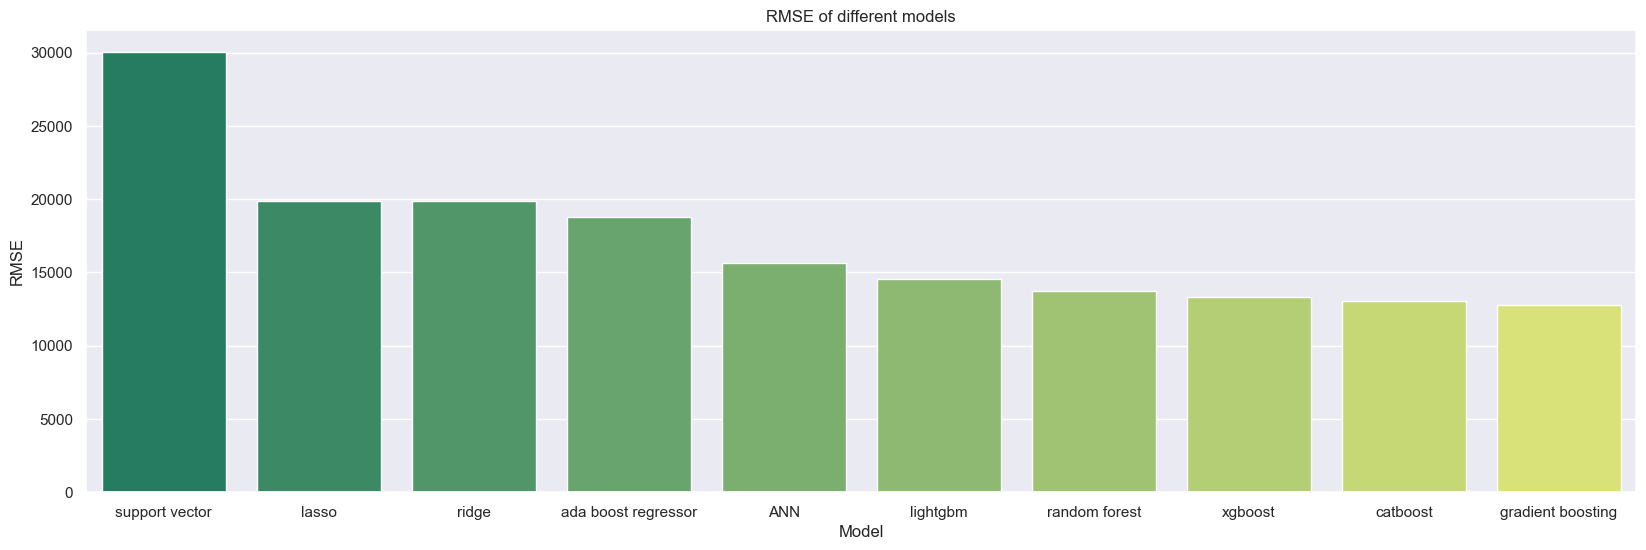

In [37]:
plt.figure(figsize = (20, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'summer')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');

# CREATING THE JOBLIB FILE FOR EASY INCUSION OF THE TRAINED MODEL IN THE UI

In [39]:
#creating a easy way to import the trained model to the ui
import joblib

# Save the trained model
joblib.dump(model, 'model.joblib')

['model.joblib']